Project IS 669 Big Data and Information Systems 
#Group Members :

1. Ajay Eslavath
2. **PRANAY KUMAR REDDY GANGIREDDY**.
3. Prashanth Narayana Gondlyala Sathya
4. Aakash Janardhan Jadhav
5. Sasi Kumar Kandibilla Bhaskar

# Import Statements 

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import mysql.connector

# Database Schema Diagram

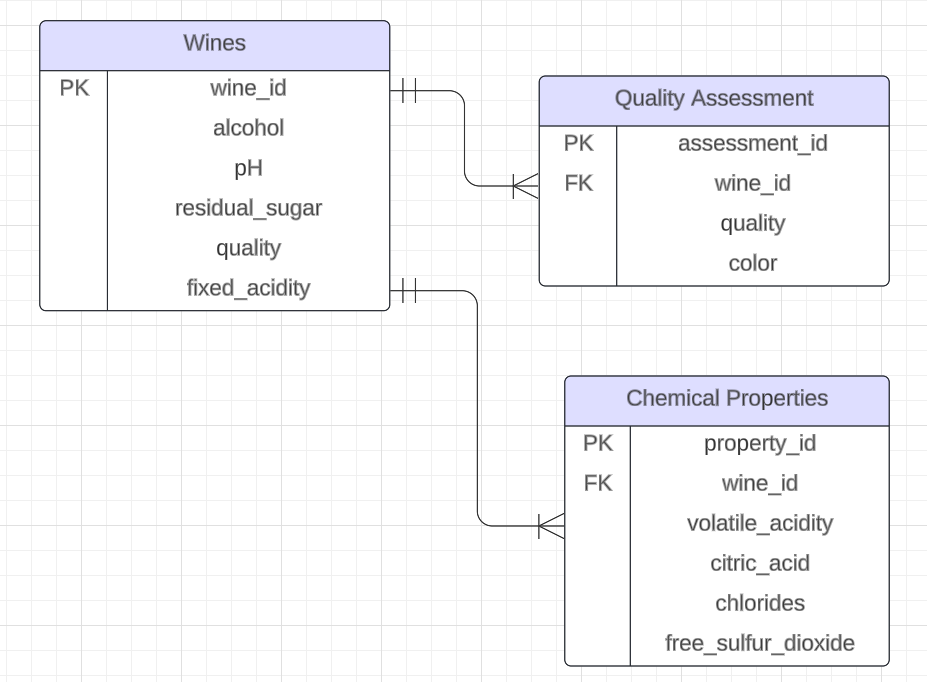

# Database Connection Code 

In [2]:
# Establish a connection to the MySQL server
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='localhost'
)

# Create a cursor to execute SQL queries
cursor = connection.cursor()

# Create a new database
database_name = 'winequality_db'
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")

# Check if the database is created
cursor.execute(f"SHOW DATABASES LIKE '{database_name}'")
database_exists = cursor.fetchone()

if database_exists:
    print(f"Database '{database_name}' is created.")
else:
    print(f"Failed to create database '{database_name}'.")

# Don't forget to close the connection
connection.close()


Database 'winequality_db' is created.


# Database Connection Code Part-1

In [3]:

# Establish a connection to the MySQL server
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='localhost'
)

# Create a cursor to execute SQL queries
cursor = connection.cursor()


# Connect to the created database
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='localhost',
    database=database_name
)

# Create a cursor to execute SQL queries within the database
cursor = connection.cursor()

# Create Wines table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS Wines (
        wine_id INT AUTO_INCREMENT PRIMARY KEY,
        residual_sugar FLOAT,
        fixed_acidity FLOAT,
        pH FLOAT,
        alcohol FLOAT,
        quality INT
    )
""")

# Create ChemicalProperties table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS ChemicalProperties (
        property_id INT AUTO_INCREMENT PRIMARY KEY,
        wine_id INT,
        volatile_acidity FLOAT,
        citric_acid FLOAT,
        chlorides FLOAT,
        free_sulfur_dioxide FLOAT,
        FOREIGN KEY (wine_id) REFERENCES Wines(wine_id)
    )
""")

# Create QualityAssessment table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS QualityAssessment (
        assessment_id INT AUTO_INCREMENT PRIMARY KEY,
        wine_id INT,
        quality INT,
        color VARCHAR(10),
        FOREIGN KEY (wine_id) REFERENCES Wines(wine_id)
    )
""")

# Commit changes and close the connection
connection.commit()
connection.close()


# Table Population Code Part-2 

In [4]:
# Connecting to MySQL server
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="winequality_db"
)

# Creating a cursor
cursor = connection.cursor()

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality. data.features
y = wine_quality.data.targets

# variable information
url = 'https://archive.ics.uci.edu/static/public/186/data.csv'

# Reading the CSV file into a DataFrame
df = pd.read_csv(url)

# Splitting the dataset into two halves
half_len = len(df) // 2
training = df.iloc[:half_len].reset_index(drop=True)
testing = df.iloc[half_len:].reset_index(drop=True)

# Creating Training Table
columns_str = ', '.join([f'{col} TEXT' for col in training.columns])
create_training_table_query = f"CREATE TABLE IF NOT EXISTS training ({columns_str})"
cursor.execute(create_training_table_query)

# Creating Testing Table
columns_str = ', '.join([f'{col} TEXT' for col in testing.columns])
create_testing_table_query = f"CREATE TABLE IF NOT EXISTS testing ({columns_str})"
cursor.execute(create_testing_table_query)

# Creating Synthetic Data Table

# Assuming 'df' is your original DataFrame
original_data = df.copy()

# Number of additional instances to generate
num_additional_instances = 2000

# Generate synthetic data within the range of each feature
synthetic_data = pd.DataFrame()

for column in original_data.columns:
    # If the column has numeric values
    if pd.api.types.is_numeric_dtype(original_data[column]):
        # Calculating the range of the original data in the column
        data_range = original_data[column].max() - original_data[column].min()

        # Generate random values within the range of the original data
        synthetic_values = np.random.uniform(
            low=original_data[column].min(),
            high=original_data[column].max(),
            size=num_additional_instances
        )

        # Add the synthetic values to the new DataFrame
        synthetic_data[column] = synthetic_values

columns_str = ', '.join([f'{col} TEXT' for col in synthetic_data.columns])
create_synthetic_table_query = f"CREATE TABLE IF NOT EXISTS Synthetic_Data ({columns_str})"
cursor.execute(create_synthetic_table_query)

# Inserting records into Synthetic_Data Table
for _, row in synthetic_data.iterrows():
    insert_synthetic_query = f"INSERT INTO Synthetic_Data VALUES ({', '.join(['%s']*len(row))})"
    cursor.execute(insert_synthetic_query, tuple(row))

# Fetching and printing the inserted values from the Synthetic Data table
cursor.execute("SELECT * FROM Synthetic_Data LIMIT 3")  
result_synthetic = cursor.fetchall()
print("\nSynthetic_Data Table:")
for row in result_synthetic:
    print(row)

# Committing the changes
connection.commit()

cursor.close()
connection.close()



Synthetic_Data Table:
('5.823192731650974', '0.6920069744078633', '0.3019931372898562', '9.812421024237926', '0.2924607952100124', '24.230737814879323', '431.80059469042857', '1.0229903116176315', '3.0694796484385174', '1.9355154175396678', '11.635760770512158', '8.615955690877101')
('8.725820636407423', '0.13450008242643635', '0.801140984500278', '32.77502026420613', '0.4575784073873476', '233.5444163547547', '187.19223713145627', '1.01354643845971', '3.3951428114337947', '1.6279465734380805', '9.376273219060991', '5.136479532907582')
('14.030056984249331', '0.23588665237823564', '0.3680101970951418', '4.325627093174083', '0.09651266269203268', '227.3753690359129', '7.82000751321903', '1.0371795392678071', '3.28885754338094', '1.6102856690731875', '14.021595976150506', '3.771016927981425')


In [5]:
def create_connection():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="winequality_db"
    )

def insert_into_table(connection, data, table_name):
    with connection.cursor() as cursor:
        for _, row in data.iterrows():
            insert_query = f"INSERT INTO {table_name} VALUES ({', '.join(['%s']*len(row))})"
            cursor.execute(insert_query, tuple(row))
        connection.commit()

def fetch_and_print_values(connection, table_name, limit=2):
    cursor = connection.cursor(dictionary=True)
    cursor.execute(f"SELECT * FROM {table_name} LIMIT {limit}")
    result = cursor.fetchall()
    print(f"\n{table_name} Table:")
    for row in result:
        print(row)
    cursor.close()

# Splitting the dataset into two halves
half_len = len(df) // 2
training = df.iloc[:half_len].reset_index(drop=True)
testing = df.iloc[half_len:].reset_index(drop=True)

# Creating connections
connection = create_connection()

# Creating a cursor within a 'with' statement for iteration over DataFrame
with connection.cursor() as cursor:
    
    # Iterating over rows in the DataFrame and inserting data into the Wines table
    for _, row in df[['residual_sugar', 'fixed_acidity', 'pH', 'alcohol', 'quality']].iterrows():
        cursor.execute('''
            INSERT INTO Wines (residual_sugar, fixed_acidity, pH, alcohol, quality)
            VALUES (%s, %s, %s, %s, %s)
        ''', tuple(row))

        # Committing changes after inserting into Wines
        connection.commit()

        # Fetching the wine_id from the last insertion
        cursor.execute("SELECT LAST_INSERT_ID()")
        wine_id = cursor.fetchone()[0]

        # Now, inserting data into ChemicalProperties table
        chemical_properties_row = df.loc[df.index == row.name, ['volatile_acidity', 'citric_acid', 'chlorides', 'free_sulfur_dioxide']].iloc[0]

        cursor.execute('''
            INSERT INTO ChemicalProperties (wine_id, volatile_acidity, citric_acid, chlorides, free_sulfur_dioxide)
            VALUES (%s, %s, %s, %s, %s)
        ''', (wine_id, chemical_properties_row['volatile_acidity'], chemical_properties_row['citric_acid'], chemical_properties_row['chlorides'], chemical_properties_row['free_sulfur_dioxide']))

        # Committing changes after inserting into ChemicalProperties
        connection.commit()

    

# Now, inserting data into QualityAssessment table
        quality_assessment_row = df.loc[df.index == row.name, ['quality', 'color']].iloc[0]
        cursor.execute('''
            INSERT INTO QualityAssessment (wine_id, quality, color)
            VALUES (%s, %s, %s)
        ''', (wine_id, int(quality_assessment_row['quality']), str(quality_assessment_row['color'])))

# Committing changes after inserting into QualityAssessment
connection.commit()




"""# Fetch and print the inserted values from both tables
fetch_and_print_values(connection, "Wines")
fetch_and_print_values(connection, "ChemicalProperties")
fetch_and_print_values(connection, "QualityAssessment")"""


# Define columns for the table
columns = [f"{col} TEXT" for col in df.columns]


# Calling function to insert data into the Training table
insert_into_table(connection, training, "training")

# Calling function to insert data into the Testing table
insert_into_table(connection, testing, "testing")

# Fetch and print the inserted values from both tables
fetch_and_print_values(connection, "training")
fetch_and_print_values(connection, "testing")

# Close the connection
connection.close()



training Table:
{'fixed_acidity': '7.4', 'volatile_acidity': '0.7', 'citric_acid': '0.0', 'residual_sugar': '1.9', 'chlorides': '0.076', 'free_sulfur_dioxide': '11.0', 'total_sulfur_dioxide': '34.0', 'density': '0.9978', 'pH': '3.51', 'sulphates': '0.56', 'alcohol': '9.4', 'quality': '5', 'color': 'red'}
{'fixed_acidity': '7.8', 'volatile_acidity': '0.88', 'citric_acid': '0.0', 'residual_sugar': '2.6', 'chlorides': '0.098', 'free_sulfur_dioxide': '25.0', 'total_sulfur_dioxide': '67.0', 'density': '0.9968', 'pH': '3.2', 'sulphates': '0.68', 'alcohol': '9.8', 'quality': '5', 'color': 'red'}

testing Table:
{'fixed_acidity': '6.9', 'volatile_acidity': '0.26', 'citric_acid': '0.49', 'residual_sugar': '1.6', 'chlorides': '0.058', 'free_sulfur_dioxide': '39.0', 'total_sulfur_dioxide': '166.0', 'density': '0.9965', 'pH': '3.65', 'sulphates': '0.52', 'alcohol': '9.4', 'quality': '4', 'color': 'white'}
{'fixed_acidity': '7.6', 'volatile_acidity': '0.31', 'citric_acid': '0.49', 'residual_sugar'